In [1]:
pip install nba_api      # we need to restart session always while we start running the code to import this package

In [2]:
pip install pyspark

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Starting Spark Session and Data Loading


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean

# Initializing Spark Session
spark = SparkSession.builder \
    .appName("project") \
    .getOrCreate()

# Loading data from a CSV file
df = spark.read.csv("/content/drive/Shareddrives/603 Project/Project/player_BoxPlot.csv", header=True, inferSchema=True)  # the data is taken from the google drive mounted to the code

# Imputing Missing Values with Mean

In [5]:
# Selecting only numeric columns
numeric_columns = [c for c in df.columns if df.select(c).dtypes[0][1] in ('int', 'bigint', 'float', 'double')]

# Calculating means for numeric columns
means = df.select([mean(col(c)).alias(c) for c in numeric_columns]).collect()[0].asDict()

# Filling missing values with the mean of each column calculated
df = df.na.fill(means)

#imputing missing vales
from pyspark.sql.functions import col, sum as pyspark_sum

# Counting null values in each column, to verify no missing values after imputation
null_counts = df.select([pyspark_sum(col(c).isNull().cast('integer')).alias(c) for c in df.columns])

# displaying the counts
null_counts.show()

+----------+---------+-----------+-------+-----------------+---------+-------+---------+-------+---+---+---+---+------+----+----+-------+---+---+------+----+----+---+---+---+---+---+---+---+----------+-----------+---------------+-----------+
|SEASON_ID0|PLAYER_ID|PLAYER_NAME|TEAM_ID|TEAM_ABBREVIATION|TEAM_NAME|GAME_ID|GAME_DATE|MATCHUP| WL|MIN|FGM|FGA|FG_PCT|FG3M|FG3A|FG3_PCT|FTM|FTA|FT_PCT|OREB|DREB|REB|AST|STL|BLK|TOV| PF|PTS|PLUS_MINUS|FANTASY_PTS|VIDEO_AVAILABLE|season_id32|
+----------+---------+-----------+-------+-----------------+---------+-------+---------+-------+---+---+---+---+------+----+----+-------+---+---+------+----+----+---+---+---+---+---+---+---+----------+-----------+---------------+-----------+
|         0|        0|          0|      0|                0|        0|      0|        0|      0|  0|  0|  0|  0|     0|   0|   0|      0|  0|  0|     0|   0|   0|  0|  0|  0|  0|  0|  0|  0|         0|          0|              0|          0|
+----------+---------+----------

# Data Preprocessing

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, when, col

# Defining a function to split 'MATCHUP' into 'HOME_TEAM' and 'AWAY_TEAM'
df = df.withColumn("HOME_TEAM", when(col("MATCHUP").contains(" vs. "), split(col("MATCHUP"), " vs. ").getItem(0))
                                 .otherwise(split(col("MATCHUP"), " @ ").getItem(1)))
df = df.withColumn("AWAY_TEAM", when(col("MATCHUP").contains(" @ "), split(col("MATCHUP"), " @ ").getItem(0))
                                 .otherwise(split(col("MATCHUP"), " vs. ").getItem(1)))
# Drop the 'MATCHUP' column
df = df.drop("MATCHUP","FANTASY_PTS","VIDEO_AVAILABLE","season_id32")

In [7]:
from pyspark.sql.functions import year, month, dayofmonth

# Splitting the timestamp column into year, month, and day columns
df = df.withColumn("year", year("GAME_DATE")) \
       .withColumn("month", month("GAME_DATE")) \
       .withColumn("day", dayofmonth("GAME_DATE"))

# Droping the original timestamp column
df = df.drop("GAME_DATE")

# displaying the DataFrame with the new columns
df.show(8)

+----------+---------+-------------+----------+-----------------+-----------------+--------+---+---+---+---+------+----+----+------------------+---+---+------------------+----+----+---+---+---+---+---+---+---+----------+---------+---------+----+-----+---+
|SEASON_ID0|PLAYER_ID|  PLAYER_NAME|   TEAM_ID|TEAM_ABBREVIATION|        TEAM_NAME| GAME_ID| WL|MIN|FGM|FGA|FG_PCT|FG3M|FG3A|           FG3_PCT|FTM|FTA|            FT_PCT|OREB|DREB|REB|AST|STL|BLK|TOV| PF|PTS|PLUS_MINUS|HOME_TEAM|AWAY_TEAM|year|month|day|
+----------+---------+-------------+----------+-----------------+-----------------+--------+---+---+---+---+------+----+----+------------------+---+---+------------------+----+----+---+---+---+---+---+---+---+----------+---------+---------+----+-----+---+
|     21996|     1041|Nate Driggers|1610612738|              BOS|   Boston Celtics|29601182|  L| 19|  2|  5|   0.4|   0|   1|               0.0|  2|  3|             0.667|   1|   1|  2|  2|  0|  0|  1|  0|  6|       -10|      BOS|  

In [8]:
features=df.columns           #displaying the columns
features.remove("WL")
", ".join(features)

'SEASON_ID0, PLAYER_ID, PLAYER_NAME, TEAM_ID, TEAM_ABBREVIATION, TEAM_NAME, GAME_ID, MIN, FGM, FGA, FG_PCT, FG3M, FG3A, FG3_PCT, FTM, FTA, FT_PCT, OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS, PLUS_MINUS, HOME_TEAM, AWAY_TEAM, year, month, day'

# Accessing Live Data

In [9]:
import requests
import pandas as pd

headers  = {                                        #header used for web scrapping, obtained from youtube video
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

# this url is obtained from inspecting the real time game to obtain the box score statstics of a real time match

url_box_score='https://cdn.nba.com/static/json/liveData/boxscore/boxscore_0042300124.json'
response = requests.get(url=url_box_score, headers=headers).json()

https://www.nba.com/game/mil-vs-ind-0042300124   # this is the game we have used for our project

# Extracting live data statistics of Team 1

In [10]:
# code to extract live data from the nba site for team 1 (here team 1 is home team)
player_stats = {}
for i in range(0,len(response['game']['homeTeam']['players'])):
    player_stats[response['game']['homeTeam']['players'][i]['personId'] ]= response['game']['homeTeam']['players'][i]['statistics']

player_df = pd.DataFrame(player_stats, index = player_stats.keys())

# Converting the dictionary into a list of dictionaries
player_stats_list = [{'player_id': player_id, **stats} for player_id, stats in player_stats.items()]

# Creating a DataFrame from the list of dictionaries
player_stats_team1_df = pd.DataFrame(player_stats_list)

player_stats_team1_df.head(3)

,player_id,assists,blocks,blocksReceived,fieldGoalsAttempted,fieldGoalsMade,fieldGoalsPercentage,foulsOffensive,foulsDrawn,foulsPersonal,...,reboundsOffensive,reboundsTotal,steals,threePointersAttempted,threePointersMade,threePointersPercentage,turnovers,twoPointersAttempted,twoPointersMade,twoPointersPercentage
0,1630174,1,2,0,6,3,0.500000,0,4,4,...,1,3,0,5,3,0.600000,1,1,0,0.000
1,1627783,7,1,1,14,6,0.428571,0,6,2,...,1,9,2,4,0,0.000000,0,10,6,0.600
2,1626167,4,3,1,17,10,0.588235,0,4,5,...,1,9,0,9,7,0.777778,0,8,3,0.375


# Extracting live data statistics of Team 2

In [11]:
# same code as above for team 2 (away team)

player_stats = {}
for i in range(0,len(response['game']['awayTeam']['players'])):
    player_stats[response['game']['awayTeam']['players'][i]['personId'] ]= response['game']['awayTeam']['players'][i]['statistics']

player_df = pd.DataFrame(player_stats, index = player_stats.keys())

player_stats_list = [{'player_id': player_id, **stats} for player_id, stats in player_stats.items()]

player_stats_team2_df = pd.DataFrame(player_stats_list)

player_stats_team2_df.head(3)

,player_id,assists,blocks,blocksReceived,fieldGoalsAttempted,fieldGoalsMade,fieldGoalsPercentage,foulsOffensive,foulsDrawn,foulsPersonal,...,reboundsOffensive,reboundsTotal,steals,threePointersAttempted,threePointersMade,threePointersPercentage,turnovers,twoPointersAttempted,twoPointersMade,twoPointersPercentage
0,203114,5,0,2,22,9,0.409091,0,8,4,...,1,10,1,4,0,0.0,4,18,9,0.500000
1,1626171,0,0,0,4,2,0.500000,0,0,0,...,0,3,0,1,0,0.0,0,3,2,0.666667
2,201572,1,1,2,18,12,0.666667,0,5,0,...,3,9,0,5,3,0.6,3,13,9,0.692308


# Data Preprocessing of Real Time data

Dropping of columns

In [12]:
columns_to_drop = ['blocksReceived', 'foulsOffensive', 'foulsDrawn', 'foulsTechnical', 'minus', 'minutesCalculated', 'plus', 'pointsFastBreak', 'pointsInThePaint', 'pointsSecondChance', 'twoPointersAttempted', 'twoPointersMade', 'twoPointersPercentage']
# Droping the specified columns from the DataFrame, to make sure this datascheme matches with the existing historical data available, which is made ready earlier
player_stats_team1_df = player_stats_team1_df.drop(columns=columns_to_drop)
player_stats_team2_df = player_stats_team2_df.drop(columns=columns_to_drop)

player_stats_team1_df.columns

Index(['player_id', 'assists', 'blocks', 'fieldGoalsAttempted',
       'fieldGoalsMade', 'fieldGoalsPercentage', 'foulsPersonal',
       'freeThrowsAttempted', 'freeThrowsMade', 'freeThrowsPercentage',
       'minutes', 'plusMinusPoints', 'points', 'reboundsDefensive',
       'reboundsOffensive', 'reboundsTotal', 'steals',
       'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'turnovers'],
      dtype='object')

Mapping Columns of real time data with the Historical data columns

In [13]:
# Defining the mapping of old column names to new column names, to ensure the naming for real time data is same as historical data
column_name_mapping = {
    'player_id': 'PLAYER_ID',
    'assists': 'AST',
    'blocks': 'BLK',
    'fieldGoalsAttempted': 'FGA',
    'fieldGoalsMade': 'FGM',
    'fieldGoalsPercentage': 'FG_PCT',
    'foulsPersonal': 'PF',
    'freeThrowsAttempted': 'FTA',
    'freeThrowsMade': 'FTM',
    'freeThrowsPercentage': 'FT_PCT',
    'minutes': 'MIN',
    'plusMinusPoints': 'PLUS_MINUS',
    'points': 'PTS',
    'reboundsDefensive': 'DREB',
    'reboundsOffensive': 'OREB',
    'reboundsTotal': 'REB',
    'steals': 'STL',
    'threePointersAttempted': 'FG3A',
    'threePointersMade': 'FG3M',
    'threePointersPercentage': 'FG3_PCT',
    'turnovers': 'TOV'}

# Renaming the columns of the DataFrame
player_stats_team1_df = player_stats_team1_df.rename(columns=column_name_mapping)
player_stats_team2_df = player_stats_team2_df.rename(columns=column_name_mapping)

player_stats_team1_df.columns

Index(['PLAYER_ID', 'AST', 'BLK', 'FGA', 'FGM', 'FG_PCT', 'PF', 'FTA', 'FTM',
       'FT_PCT', 'MIN', 'PLUS_MINUS', 'PTS', 'DREB', 'OREB', 'REB', 'STL',
       'FG3A', 'FG3M', 'FG3_PCT', 'TOV'],
      dtype='object')

In [14]:
'''This code section adds features to real time data which exist in historical data so as to make both data have same features'''

# for team 1
# Adding the new feature 'SEASON_ID0' with corresponding data '22023' to the DataFrame
player_stats_team1_df['SEASON_ID0'] = 22023

#game_id
player_stats_team1_df['GAME_ID'] =int(response['game']['gameId'][-8:])

#player_name
player_names = {}

for i in range(0,len(response['game']['homeTeam']['players'])):
    player_names[response['game']['homeTeam']['players'][i]['personId']] = response['game']['homeTeam']['players'][i]['name']

player_stats_team1_df['PLAYER_NAME'] = player_stats_team1_df['PLAYER_ID'].map(player_names)

#team name, team abbreviation, team id, hometeam , awayteam
player_stats_team1_df['TEAM_NAME'] = response['game']['homeTeam']['teamCity'] +' '+ response['game']['homeTeam']['teamName']
player_stats_team1_df['TEAM_ABBREVIATION'] = response['game']['homeTeam']['teamTricode']
player_stats_team1_df['TEAM_ID'] = response['game']['homeTeam']['teamId']
player_stats_team1_df['HOME_TEAM']= response['game']['homeTeam']['teamTricode']
player_stats_team1_df['AWAY_TEAM']= response['game']['awayTeam']['teamTricode']

#date, month, year
import datetime

# Assuming response is a dictionary containing the game time information
game_time_local = response['game']['gameTimeLocal']

# Parsing the game time string into a datetime object
game_time_dt = datetime.datetime.strptime(game_time_local, '%Y-%m-%dT%H:%M:%S%z')

# Adding day, month, and year columns to the DataFrame
player_stats_team1_df['day'] = game_time_dt.day
player_stats_team1_df['month'] = game_time_dt.month
player_stats_team1_df['year'] = game_time_dt.year

player_stats_team1_df.head(5)

,PLAYER_ID,AST,BLK,FGA,FGM,FG_PCT,PF,FTA,FTM,FT_PCT,...,GAME_ID,PLAYER_NAME,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,HOME_TEAM,AWAY_TEAM,day,month,year
0,1630174,1,2,6,3,0.500000,4,4,4,1.000000,...,42300124,Aaron Nesmith,Indiana Pacers,IND,1610612754,IND,MIL,28,4,2024
1,1627783,7,1,14,6,0.428571,2,3,1,0.333333,...,42300124,Pascal Siakam,Indiana Pacers,IND,1610612754,IND,MIL,28,4,2024
2,1626167,4,3,17,10,0.588235,5,6,2,0.333333,...,42300124,Myles Turner,Indiana Pacers,IND,1610612754,IND,MIL,28,4,2024
3,1629614,9,0,9,6,0.666667,2,0,0,0.000000,...,42300124,Andrew Nembhard,Indiana Pacers,IND,1610612754,IND,MIL,28,4,2024
4,1630169,4,0,16,8,0.500000,0,3,3,1.000000,...,42300124,Tyrese Haliburton,Indiana Pacers,IND,1610612754,IND,MIL,28,4,2024


In [15]:
# for team 2
# Adding the new feature 'SEASON_ID0' with corresponding data '22023' to the DataFrame
player_stats_team2_df['SEASON_ID0'] = 22023

#game_id
player_stats_team2_df['GAME_ID'] = int(response['game']['gameId'][-8:])

#player_name
player_names = {}

for i in range(0,len(response['game']['awayTeam']['players'])):
    player_names[response['game']['awayTeam']['players'][i]['personId']] = response['game']['awayTeam']['players'][i]['name']

player_stats_team2_df['PLAYER_NAME'] = player_stats_team2_df['PLAYER_ID'].map(player_names)

#team name, team abbreviation, team id, hometeam , awayteam
player_stats_team2_df['TEAM_NAME'] = response['game']['awayTeam']['teamCity'] +' '+ response['game']['awayTeam']['teamName']
player_stats_team2_df['TEAM_ABBREVIATION'] = response['game']['awayTeam']['teamTricode']
player_stats_team2_df['TEAM_ID'] = response['game']['awayTeam']['teamId']
player_stats_team2_df['HOME_TEAM']= response['game']['homeTeam']['teamTricode']
player_stats_team2_df['AWAY_TEAM']= response['game']['awayTeam']['teamTricode']

#date, month, year
import datetime

# Assuming response is a dictionary containing the game time information
game_time_local = response['game']['gameTimeLocal']

# Parsing the game time string into a datetime object
game_time_dt = datetime.datetime.strptime(game_time_local, '%Y-%m-%dT%H:%M:%S%z')

# Adding day, month, and year columns to the DataFrame
player_stats_team2_df['day'] = game_time_dt.day
player_stats_team2_df['month'] = game_time_dt.month
player_stats_team2_df['year'] = game_time_dt.year

player_stats_team2_df.head(5)

,PLAYER_ID,AST,BLK,FGA,FGM,FG_PCT,PF,FTA,FTM,FT_PCT,...,GAME_ID,PLAYER_NAME,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,HOME_TEAM,AWAY_TEAM,day,month,year
0,203114,5,0,22,9,0.409091,4,8,7,0.875,...,42300124,Khris Middleton,Milwaukee Bucks,MIL,1610612749,IND,MIL,28,4,2024
1,1626171,0,0,4,2,0.500000,0,0,0,0.000,...,42300124,Bobby Portis,Milwaukee Bucks,MIL,1610612749,IND,MIL,28,4,2024
2,201572,1,1,18,12,0.666667,0,4,0,0.000,...,42300124,Brook Lopez,Milwaukee Bucks,MIL,1610612749,IND,MIL,28,4,2024
3,1627736,2,0,12,8,0.666667,1,0,0,0.000,...,42300124,Malik Beasley,Milwaukee Bucks,MIL,1610612749,IND,MIL,28,4,2024
4,201976,4,0,6,3,0.500000,1,2,2,1.000,...,42300124,Patrick Beverley,Milwaukee Bucks,MIL,1610612749,IND,MIL,28,4,2024


In [16]:
# List containing the desired order of columns
desired_order = features
# Reordering the columns in the DataFrame to make sure both the real time and hostorical data are in same order
player_stats_team1_df = player_stats_team1_df.reindex(columns=desired_order)
player_stats_team2_df = player_stats_team2_df.reindex(columns=desired_order)

In [17]:
# changing the format of minutes and extract the number of minutes from 'MIN' Column

import re
# Assuming player_stats_df is your DataFrame containing the 'min' column
# Function to extract minutes from duration string
def extract_minutes(duration):
    # Use regex to match minutes (digits before 'M')
    match = re.search(r'(\d+)M', duration)
    if match:
        # Extract minutes from the matched group
        minutes = int(match.group(1))
        return minutes
    else:
        return None  # Return None if no match found

# Apply the function to the 'min' column and create a new column 'minutes'
player_stats_team1_df['MIN'] = player_stats_team1_df['MIN'].apply(extract_minutes)
player_stats_team2_df['MIN'] = player_stats_team2_df['MIN'].apply(extract_minutes)


player_stats_team1_df = spark.createDataFrame(player_stats_team1_df)     #creating spark dataframe from pandas dataframe
player_stats_team2_df = spark.createDataFrame(player_stats_team2_df)

player_stats_team1_df.show(5)

+----------+---------+-----------------+----------+-----------------+--------------+--------+---+---+---+------------------+----+----+-----------------+---+---+-----------------+----+----+---+---+---+---+---+---+---+----------+---------+---------+----+-----+---+
|SEASON_ID0|PLAYER_ID|      PLAYER_NAME|   TEAM_ID|TEAM_ABBREVIATION|     TEAM_NAME| GAME_ID|MIN|FGM|FGA|            FG_PCT|FG3M|FG3A|          FG3_PCT|FTM|FTA|           FT_PCT|OREB|DREB|REB|AST|STL|BLK|TOV| PF|PTS|PLUS_MINUS|HOME_TEAM|AWAY_TEAM|year|month|day|
+----------+---------+-----------------+----------+-----------------+--------------+--------+---+---+---+------------------+----+----+-----------------+---+---+-----------------+----+----+---+---+---+---+---+---+---+----------+---------+---------+----+-----+---+
|     22023|  1630174|    Aaron Nesmith|1610612754|              IND|Indiana Pacers|42300124| 37|  3|  6|               0.5|   3|   5|              0.6|  4|  4|              1.0|   1|   2|  3|  1|  0|  2|  1|  4

In [18]:
from pyspark.sql.functions import col

numeric_columns = [col_name for col_name, col_type in player_stats_team1_df.dtypes if col_type != 'string' and col_type!='double']

# Converting numeric columns to integer datatype
for col_name in numeric_columns:
    player_stats_team1_df = player_stats_team1_df.withColumn(col_name, col(col_name).cast("int"))
#player_stats_team1_df.dtypes

In [19]:
from pyspark.sql.functions import col

numeric_columns = [col_name for col_name, col_type in player_stats_team2_df.dtypes if col_type != 'string' and col_type!= 'double']

# Converting numeric columns to integer datatype
for col_name in numeric_columns:
    player_stats_team2_df = player_stats_team2_df.withColumn(col_name, col(col_name).cast("int"))
#player_stats_team2_df.dtypes

In [20]:
string_columns_test = [col_name for col_name, col_type in player_stats_team1_df.dtypes if col_type == 'string']
string_columns_test                   #columns which are string the data, which should be encoded

['PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'HOME_TEAM', 'AWAY_TEAM']

# Encoding of Both real time and history data  

In [21]:
from pyspark.sql.functions import when
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

# Listing columns with string data type
string_columns = [col_name for col_name, col_type in df.dtypes if col_type == 'string']

# Creating a dictionary to store mapping between original values and encoded values
encoding_map = {}

# Replacing each string column with its encoded values
for col_name in string_columns:
    # Creating a StringIndexer to fit the column and retrieve mapping
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index",handleInvalid="keep").fit(df)
    # Getting the mapping of original values to encoded values
    encoding_map[col_name] = dict(enumerate(indexer.labels))
    # Replacing the original values with encoded values in the DataFrame
    df = indexer.transform(df).drop(col_name).withColumnRenamed(col_name + "_index", col_name)
    if col_name!='WL':
      player_stats_team1_df = indexer.transform(player_stats_team1_df).drop(col_name).withColumnRenamed(col_name + "_index", col_name)
      player_stats_team2_df = indexer.transform(player_stats_team2_df).drop(col_name).withColumnRenamed(col_name + "_index", col_name)


from pyspark.sql.functions import col

# Listing the columns with "double" data type
double_columns = [col_name for col_name, col_type in df.dtypes if col_type == 'double']

# Converting data type of selected columns to "float"
for column in double_columns:
    df = df.withColumn(column, col(column).cast('float'))

# displaying the DataFrame with encoded string columns of history data
df.show(8)

+----------+---------+----------+--------+---+---+---+------+----+----+---------+---+---+----------+----+----+---+---+---+---+---+---+---+----------+----+-----+---+-----------+-----------------+---------+---+---------+---------+
|SEASON_ID0|PLAYER_ID|   TEAM_ID| GAME_ID|MIN|FGM|FGA|FG_PCT|FG3M|FG3A|  FG3_PCT|FTM|FTA|    FT_PCT|OREB|DREB|REB|AST|STL|BLK|TOV| PF|PTS|PLUS_MINUS|year|month|day|PLAYER_NAME|TEAM_ABBREVIATION|TEAM_NAME| WL|HOME_TEAM|AWAY_TEAM|
+----------+---------+----------+--------+---+---+---+------+----+----+---------+---+---+----------+----+----+---+---+---+---+---+---+---+----------+----+-----+---+-----------+-----------------+---------+---+---------+---------+
|     21996|     1041|1610612738|29601182| 19|  2|  5|   0.4|   0|   1|      0.0|  2|  3|     0.667|   1|   1|  2|  2|  0|  0|  1|  0|  6|       -10|1997|    4| 20|     2148.0|              3.0|      3.0|0.0|      5.0|     16.0|
|     21996|      779|1610612766|29601186| 32|  7| 15| 0.467|   1|   3|    0.333|  6

In [22]:
player_stats_team1_df.show(5) #to see the encoding of real time data of team 1

+----------+---------+----------+--------+---+---+---+------------------+----+----+-----------------+---+---+-----------------+----+----+---+---+---+---+---+---+---+----------+----+-----+---+-----------+-----------------+---------+---------+---------+
|SEASON_ID0|PLAYER_ID|   TEAM_ID| GAME_ID|MIN|FGM|FGA|            FG_PCT|FG3M|FG3A|          FG3_PCT|FTM|FTA|           FT_PCT|OREB|DREB|REB|AST|STL|BLK|TOV| PF|PTS|PLUS_MINUS|year|month|day|PLAYER_NAME|TEAM_ABBREVIATION|TEAM_NAME|HOME_TEAM|AWAY_TEAM|
+----------+---------+----------+--------+---+---+---+------------------+----+----+-----------------+---+---+-----------------+----+----+---+---+---+---+---+---+---+----------+----+-----+---+-----------+-----------------+---------+---------+---------+
|     22023|  1630174|1610612754|42300124| 37|  3|  6|               0.5|   3|   5|              0.6|  4|  4|              1.0|   1|   2|  3|  1|  0|  2|  1|  4| 13|      13.0|2024|    4| 28|     1147.0|              8.0|      6.0|      7.0|   

In [23]:
player_stats_team2_df.show(5) #to see the encoding of real time data of team 2

+----------+---------+----------+--------+---+---+---+-----------------+----+----+------------------+---+---+------+----+----+---+---+---+---+---+---+---+----------+----+-----+---+-----------+-----------------+---------+---------+---------+
|SEASON_ID0|PLAYER_ID|   TEAM_ID| GAME_ID|MIN|FGM|FGA|           FG_PCT|FG3M|FG3A|           FG3_PCT|FTM|FTA|FT_PCT|OREB|DREB|REB|AST|STL|BLK|TOV| PF|PTS|PLUS_MINUS|year|month|day|PLAYER_NAME|TEAM_ABBREVIATION|TEAM_NAME|HOME_TEAM|AWAY_TEAM|
+----------+---------+----------+--------+---+---+---+-----------------+----+----+------------------+---+---+------+----+----+---+---+---+---+---+---+---+----------+----+-----+---+-----------+-----------------+---------+---------+---------+
|     22023|   203114|1610612749|42300124| 39|  9| 22|0.409090909090909|   0|   4|               0.0|  7|  8| 0.875|   1|   9| 10|  5|  1|  0|  4|  4| 25|      -6.0|2024|    4| 28|      274.0|             13.0|     11.0|      7.0|     11.0|
|     22023|  1626171|1610612749|423

In [24]:
for col_name, mapping in encoding_map.items():
    print(f"{col_name}: {mapping}")                       #encoding map to see how each feature is encoded to different indexes/values

PLAYER_NAME: {0: 'Vince Carter', 1: 'Dirk Nowitzki', 2: 'LeBron James', 3: 'Jason Terry', 4: 'Tim Duncan', 5: 'Kevin Garnett', 6: 'Kobe Bryant', 7: 'Paul Pierce', 8: 'Jamal Crawford', 9: 'Andre Miller', 10: 'Ray Allen', 11: 'Derek Fisher', 12: 'Joe Johnson', 13: 'Carmelo Anthony', 14: 'Tony Parker', 15: 'Dwight Howard', 16: 'Kyle Korver', 17: 'Andre Iguodala', 18: 'Jason Kidd', 19: 'Pau Gasol', 20: 'Steve Nash', 21: 'Chris Paul', 22: 'Richard Jefferson', 23: 'Shawn Marion', 24: 'Tyson Chandler', 25: 'Thaddeus Young', 26: 'Lou Williams', 27: 'Rudy Gay', 28: 'Trevor Ariza', 29: 'Zach Randolph', 30: 'Jeff Green', 31: 'Zaza Pachulia', 32: 'Russell Westbrook', 33: 'Ben Wallace', 34: 'Paul Millsap', 35: 'Antawn Jamison', 36: 'Kyle Lowry', 37: 'LaMarcus Aldridge', 38: 'Marvin Williams', 39: 'Boris Diaw', 40: 'Juwan Howard', 41: 'Elton Brand', 42: 'Manu Ginobili', 43: 'Dwyane Wade', 44: 'Rashard Lewis', 45: 'Rasheed Wallace', 46: 'Chauncey Billups', 47: 'Kurt Thomas', 48: 'David West', 49: 'Mi

# Machine Learning Models

In [25]:
'''We have built three classifiers (LogisticRegression, RandomForestClassifier, DecisionTreeClassifier) and choosen the best performing classifier for using it for predicting the result of real time game
using the real time data processed earlier. We can also see performance of three classifiers with respect to Area under the ROC curve(AUC ROC Curve).'''

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

# Assemble all feature columns into a single feature vector
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Split the data into training and test sets
(train_data, test_data) = df.randomSplit([0.7, 0.3])

# Define classifiers with regular parameters
lr = LogisticRegression(featuresCol="features", labelCol="WL", maxIter=10, regParam=0.01)
rf = RandomForestClassifier(featuresCol="features", labelCol="WL", numTrees=20, maxDepth=5)
dt = DecisionTreeClassifier(featuresCol="features", labelCol="WL", maxDepth=5)

# Define evaluator
evaluator = BinaryClassificationEvaluator(labelCol="WL")

# Define pipelines
lr_pipeline = Pipeline(stages=[assembler, lr])
rf_pipeline = Pipeline(stages=[assembler, rf])
dt_pipeline = Pipeline(stages=[assembler, dt])

# Fit the models
lr_model = lr_pipeline.fit(train_data)
rf_model = rf_pipeline.fit(train_data)
dt_model = dt_pipeline.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
dt_predictions = dt_model.transform(test_data)

# Evaluate the models
lr_auc_roc = evaluator.evaluate(lr_predictions)
rf_auc_roc = evaluator.evaluate(rf_predictions)
dt_auc_roc = evaluator.evaluate(dt_predictions)

# Print the AUC-ROC for each model
print("Logistic Regression AUC-ROC:", lr_auc_roc)
print("Random Forest AUC-ROC:", rf_auc_roc)
print("Decision Tree AUC-ROC:", dt_auc_roc)

# Choose the best model
best_auc_roc = max(lr_auc_roc, rf_auc_roc, dt_auc_roc)
best_model_name = None
if best_auc_roc == lr_auc_roc:
    best_model_name = "Logistic Regression"
elif best_auc_roc == rf_auc_roc:
    best_model_name = "Random Forest"
else:
    best_model_name = "Decision Tree"

print("Best Model:", best_model_name)


Logistic Regression AUC-ROC: 0.8005156659446837
Random Forest AUC-ROC: 0.7963706379641728
Decision Tree AUC-ROC: 0.7152813332392892
Best Model: Logistic Regression


In [26]:
# Evaluting different performance matrics for the best model choosen above

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define BinaryClassificationEvaluator
evaluator_binary = BinaryClassificationEvaluator(labelCol="WL")

# Compute area under ROC curve (AUC) for the best model
auc = evaluator_binary.evaluate(lr_predictions)

# Compute precision for the best model
precision = lr_predictions.filter("WL == prediction").filter("prediction == 1").count() / lr_predictions.filter("prediction == 1").count()

# Compute recall for the best model
recall = lr_predictions.filter("WL == prediction").filter("prediction == 1").count() / lr_predictions.filter("WL == 1").count()

# Compute F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print("Metrics for the Best Model:")
print("Area Under ROC Curve (AUC):", auc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Metrics for the Best Model:
Area Under ROC Curve (AUC): 0.8005188365123609
Precision: 0.7160447420020115
Recall: 0.7151365721011405
F1-score: 0.7155903689075929


# Prediction of Real Time Game Result

In [27]:
prediction_team1 = lr_model.transform(player_stats_team1_df)
prediction_team1.show()

+----------+---------+----------+--------+---+---+---+-------------------+----+----+-----------------+---+---+-----------------+----+----+---+---+---+---+---+---+---+----------+----+-----+---+-----------+-----------------+---------+---------+---------+--------------------+--------------------+--------------------+----------+
|SEASON_ID0|PLAYER_ID|   TEAM_ID| GAME_ID|MIN|FGM|FGA|             FG_PCT|FG3M|FG3A|          FG3_PCT|FTM|FTA|           FT_PCT|OREB|DREB|REB|AST|STL|BLK|TOV| PF|PTS|PLUS_MINUS|year|month|day|PLAYER_NAME|TEAM_ABBREVIATION|TEAM_NAME|HOME_TEAM|AWAY_TEAM|            features|       rawPrediction|         probability|prediction|
+----------+---------+----------+--------+---+---+---+-------------------+----+----+-----------------+---+---+-----------------+----+----+---+---+---+---+---+---+---+----------+----+-----+---+-----------+-----------------+---------+---------+---------+--------------------+--------------------+--------------------+----------+
|     22023|  16301

In [28]:
prediction_team2 = lr_model.transform(player_stats_team2_df)
prediction_team2.show()

+----------+---------+----------+--------+---+---+---+-----------------+----+----+------------------+---+---+------+----+----+---+---+---+---+---+---+---+----------+----+-----+---+-----------+-----------------+---------+---------+---------+--------------------+--------------------+--------------------+----------+
|SEASON_ID0|PLAYER_ID|   TEAM_ID| GAME_ID|MIN|FGM|FGA|           FG_PCT|FG3M|FG3A|           FG3_PCT|FTM|FTA|FT_PCT|OREB|DREB|REB|AST|STL|BLK|TOV| PF|PTS|PLUS_MINUS|year|month|day|PLAYER_NAME|TEAM_ABBREVIATION|TEAM_NAME|HOME_TEAM|AWAY_TEAM|            features|       rawPrediction|         probability|prediction|
+----------+---------+----------+--------+---+---+---+-----------------+----+----+------------------+---+---+------+----+----+---+---+---+---+---+---+---+----------+----+-----+---+-----------+-----------------+---------+---------+---------+--------------------+--------------------+--------------------+----------+
|     22023|   203114|1610612749|42300124| 39|  9| 22|0

In [29]:
team1_counts= prediction_team1.groupBy("prediction").count()    #here, 'prediction' is the output column showing the status of game result (0 is loss, 1 is win)
team1_counts.show()             #number of value counts will show how many player statistics are giving the result of the game

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0|   12|
|       0.0|    3|
+----------+-----+



In [30]:
team2_counts= prediction_team2.groupBy("prediction").count()
team2_counts.show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|    8|
|       1.0|    7|
+----------+-----+



In [31]:
def decide_winner(team1_counts, team2_counts):
    """ this is the function to decide which team will win based on the number of 1's.
    Args:
    - team1_counts: Dictionary containing value counts of 0's and 1's for team 1
    - team2_counts: Dictionary containing value counts of 0's and 1's for team 2

    Returns:
    - Winning team: 'Team 1' or 'Team 2'"""

        # Get the count of 1's for team 1
    team1_ones_count = team1_counts.filter(team1_counts.prediction == 1).collect()[0]['count']

    # Get the count of 1's for team 2
    team2_ones_count = team2_counts.filter(team2_counts.prediction == 1).collect()[0]['count']

     # Checking if number of 1's for team 1 is greater than team 2
    if team1_ones_count > team2_ones_count:
        print(response['game']['homeTeam']['teamCity'] + ' ' + response['game']['homeTeam']['teamName'] + ' is the winner')
    # Checking if number of 1's for team 2 is greater than team 1
    elif team2_ones_count > team1_ones_count:
        print(response['game']['awayTeam']['teamCity'] + ' ' + response['game']['awayTeam']['teamName'] + ' is the winner')
    else:
        print('The match is a tie between ' + response['game']['homeTeam']['teamCity'] + ' ' + response['game']['homeTeam']['teamName'] + ' and ' + response['game']['awayTeam']['teamCity'] + ' ' + response['game']['awayTeam']['teamName'])


In [32]:
# Using the function created abiove to decide the winner for the real-time game data
winner_message = decide_winner(team1_counts, team2_counts)

Indiana Pacers is the winner


It is evident from the site https://www.nba.com/game/mil-vs-ind-0042300124, that the model is able to predict the winner of the game successfully

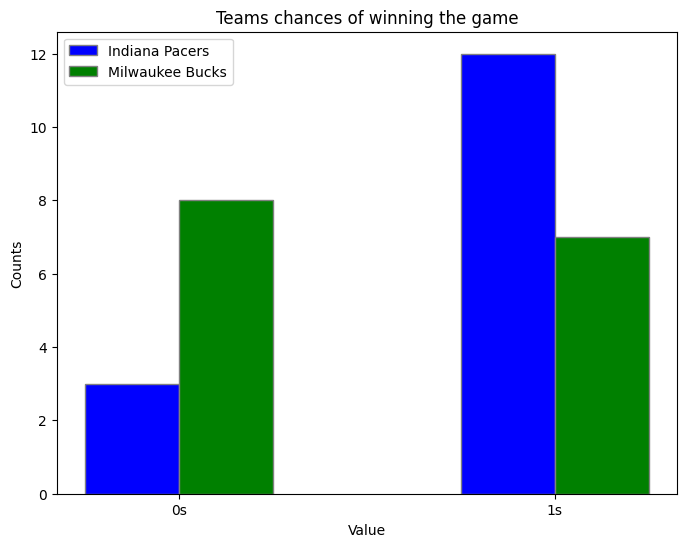

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_value_counts(team1_counts, team2_counts):
    """
    Plot grouped bar graph of value counts for both teams.

    Args:
    - team1_counts: PySpark DataFrame containing value counts of 0's and 1's for team 1
    - team2_counts: PySpark DataFrame containing value counts of 0's and 1's for team 2
    """
    # Converting PySpark DataFrame to dictionary
    team1_counts_dict = {row['prediction']: row['count'] for row in team1_counts.collect()}
    team2_counts_dict = {row['prediction']: row['count'] for row in team2_counts.collect()}

    # Extracting values and labels from the dictionaries
    team1_values = [team1_counts_dict.get(0, 0), team1_counts_dict.get(1, 0)]
    team2_values = [team2_counts_dict.get(0, 0), team2_counts_dict.get(1, 0)]
    labels = ['0s', '1s']

    # Setting width of bars
    bar_width = 0.25

    r1 = np.arange(len(team1_values))
    r2 = [x + bar_width for x in r1]

    plt.figure(figsize=(8, 6))
    plt.bar(r1, team1_values, color='blue', width=bar_width, edgecolor='grey', label=response['game']['homeTeam']['teamCity'] + ' ' + response['game']['homeTeam']['teamName'])
    plt.bar(r2, team2_values, color='green', width=bar_width, edgecolor='grey', label=response['game']['awayTeam']['teamCity'] + ' ' + response['game']['awayTeam']['teamName'])

    plt.xlabel('Value')
    plt.ylabel('Counts')
    plt.title('Teams chances of winning the game')
    plt.xticks([r + bar_width/2 for r in range(len(team1_values))], labels)
    plt.legend()
    plt.show()

plot_value_counts(team1_counts, team2_counts)
